In [29]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline  
#os.chdir('/Users/Sriram/Desktop/DePaul/Q5/CSC529/SVM-Convex-Images')
os.chdir('C:\\Users\\SYARLAG1\\Desktop\\SVM-Convex-Images')

In [4]:
train = np.genfromtxt('convex_train.amat')

### Data Preprocessing and Exploration

(Each image is 28x28)

In [5]:
train.shape

(8000L, 785L)

In [9]:
X = train[:,:-1]
Y = train[:,-1]

In [10]:
X.shape

(8000L, 784L)

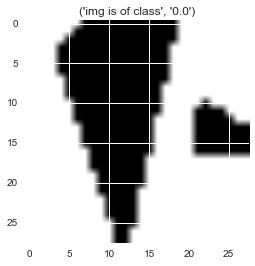

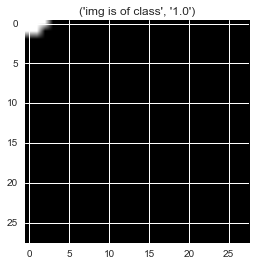

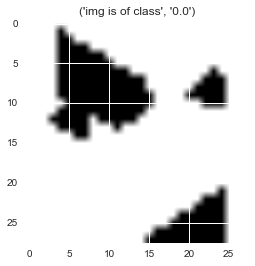

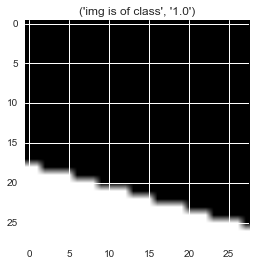

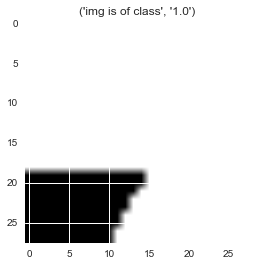

In [31]:
for i in range(5): # let us look at 5 randomly selected images
    rand_int = random.choice(range(X.shape[0]))
    img = X[rand_int]
    plt.imshow(np.reshape(img,[28,28]))
    title = 'img is of class', str(Y[rand_int])
    plt.title(title)
    plt.show()

In [ ]:
# checking if there are any NAs or invalid values


In [42]:
# visulize the datapoints using PCA
from sklearn.decomposition import PCA
pca = PCA()
pca_X = pca.fit_transform(X)

In [44]:
# variance explaied by first two components
sum(pca.explained_variance_ratio_[:2])

0.50931709227146771

(-1, 1)

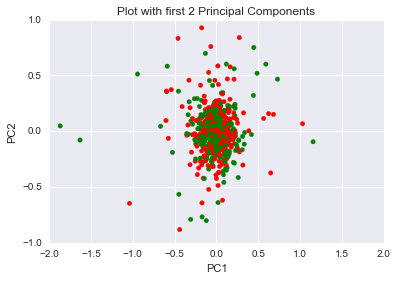

In [64]:
# plotting to see how the results look
colors = ['red' if x == 1 else 'green' for x in list(Y)]
plt.scatter(pca_X[1], pca_X[2], color=colors)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Plot with first 2 Principal Components')
# zooming in to avoid outliers
plt.xlim([-2,2])
plt.ylim([-1,1])

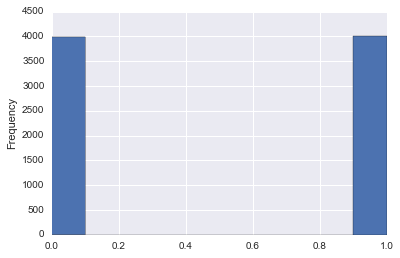

In [70]:
pd.Series(Y).plot(kind='hist') # well balanced --> can use accuracy as performance metric

In [65]:
# there doesnt seem to be any discernable pattern here

### Applying Kernel SVM on the data

In [66]:
from sklearn import svm

In [71]:
clf = svm.SVC()
clf.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
clf.score(X, Y)